<a href="https://colab.research.google.com/github/Yanina-Kutovaya/projects/blob/main/Car_insurance_renewal/notebooks/03_Car_insurance_renewal_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогноз пролонгации полиса автострахования - Модели.

## [EDA](https://github.com/Yanina-Kutovaya/projects/blob/main/Car_insurance_renewal/notebooks/01_Car_insurance_renewal_EDA.ipynb)

## [Benchmark: AutoML (PyCaret)](https://github.com/Yanina-Kutovaya/projects/blob/main/Car_insurance_renewal/notebooks/02_Car_insurance_renewal_AutoML.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import category_encoders as ce
import joblib

import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm.callback import early_stopping

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, classification_report
)
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
PATH = '/content/drive/MyDrive/ML_projects/vsk/data/'

## 1. Чтение данных

In [6]:
data_file = 'Задание (пролонгация).xlsx'
field_description = pd.read_excel(PATH + data_file, 0, header=None)
data = pd.read_excel(PATH + data_file, 1)

In [7]:
field_description

0                                                  1
0                id                                        ID договора
1            Filial                                     Филиал продажи
2           Type_ts                                             Тип ТС
3   passport_region                           Регион по серии паспорта
4               VIP                                         VIP клиент
5             Brand                                           Марка ТС
6             Model                                          Модель ТС
7     Yr_production                                     Год выпуска ТС
8               GAP                                    GAP застрахован
9           married                                               Брак
10              KBM                                                КБМ
11     KBM_prol_est                          Прогноз КБМ (пролонгация)
12        delta_kbm                                      Изменение КБМ
13           deduct                                       Тип франшизы
14    deduct_amount  Сумма франшизы (0 -без франшизы;20000- - франш...
15          product                                            Продукт
16             Bank                              Машина в залоге банка
17    channel - map                                              Канал
18         category                                        Тип бизнеса
19         kvs_type                                            Тип ЛДУ
20              Age                                            Возраст
21              Exp                                               Стаж
22         discount                                      Скидка к СППГ
23      Amount - gr                   Страховая сумм (сгруппированная)
24              sex                                                Пол
25      premium_car                                     Премиальное ТС
26         price_gr                       Сгруппированный тариф (руб.)
27        price_prc    Сгруппированный тариф (премия к сумме покрытия)
28       OSAGO_clnt                                       Клиент ОСАГО
29           target  Таргет (0 - не пролонгирован; 1 - пролонгирова...

In [8]:
print(f'data.shape = {data.shape}\n')
data.sample(5)

data.shape = (10863, 30)



ID         Filial      Type_ts        passport_region  VIP  \
10305  10306    Челябинский  Иностранные    Челябинская область  NaN   
5049    5050       Тульский  Иностранные       Тульская область  NaN   
1633    1634     Московский  Иностранные                 Москва  NaN   
5224    5225  Нижегородский  Иностранные  Нижегородская область  NaN   
1529    1530    Челябинский  Иностранные    Челябинская область  NaN   

            Brand   Model  Yr_production  GAP             married  ...  Age  \
10305      DATSUN   ON-DO           2017  Нет     Состоит в браке  ...   55   
5049   VOLKSWAGEN  TIGUAN           2018  Нет  Не состоит в браке  ...   38   
1633      HYUNDAI   CRETA           2017  Нет     Состоит в браке  ...   56   
5224          KIA     RIO           2017  Нет     Состоит в браке  ...   43   
1529          KIA     RIO           2018  Нет     Состоит в браке  ...   46   

       Exp  discount Amount - gr sex premium_car price_gr price_prc  \
10305   35      1.00      400000   F           0    10000     0.035   
5049    18      1.00     1800000   F           0    35000     0.020   
1633    17      0.95     1000000   F           0    25000     0.020   
5224    20      1.00      600000   F           0    15000     0.025   
1529    14      1.00      800000   F           0    55000     0.065   

      OSAGO_clnt target  
10305          1     -1  
5049           1      0  
1633           1      1  
5224           1      0  
1529           1      0  

[5 rows x 30 columns]

In [9]:
TARGET_NAME = 'target'

## 2. Разделение на обучающую и тестовую выбоки

In [10]:
train = data[data[TARGET_NAME] != -1]
train.shape

(7598, 30)

In [11]:
test = data[data[TARGET_NAME] == -1]
test.shape

(3265, 30)

## 3. Подготовка данных

In [12]:
def data_preparation_pipeline(train):
  train = transform_numeric_variables(train)
  train = transform_categorical_to_binary(train)
  same_regions_list = get_same_regions_list(train)
  train = get_diff_passport_region_feature(train, same_regions_list)

  glmm_encoder = ce.glmm.GLMMEncoder(cols=['Filial', 'Model'])
  train = glmm_encoder.fit_transform(train, y=train[TARGET_NAME])

  return train, same_regions_list, glmm_encoder


def data_preparation_pipeline_inference(test, same_regions_list, glmm_encoder):
  test = transform_numeric_variables(test)
  test = transform_categorical_to_binary(test)
  test = get_diff_passport_region_feature(test, same_regions_list)
  test = glmm_encoder.transform(test).drop(TARGET_NAME, axis=1)

  return test


def transform_numeric_variables(data):
  data['Yr_production'] = np.where(data['Yr_production'] == 2018, 0, 1)
  data['KBM'] = np.where(data['KBM'] >= 8, 0, 1)
  data['delta_kbm'] = np.where(data['delta_kbm'] == -100, 1, 0)
  data['Age'] = np.where(data['Age'] >= 38, 1, 0)
  data['Exp'] = np.where(data['Exp'] >= 13, 1, 0)
  data['discount'] = np.where(data['discount'] == 0.9, 1, 0)
  data['Amount - gr'] = np.where(
      (data['Amount - gr'] >= 6e05) & (data['Amount - gr'] < 1.2e06), 0, 1
  )
  data['price_gr'] = np.where(data['price_gr'] < 35000, 1, 0)
  data['price_prc'] = np.where(data['price_prc'] <= 0.04, 1, 0)

  return data


def transform_categorical_to_binary(data):
  data['Type_ts'] = np.where(data['Type_ts']=='Иностранные', 1, 0)
  data['VIP'] = np.where(data['VIP'].notnull(), 1, 0)
  data['GAP'] = np.where(data['GAP']== 'Нет', 0, 1)
  data['deduct'] = np.where(data['deduct'] == 'Без франшизы', 1, 0)
  data['product'] = np.where(data['product'] == 'Legacy', 0, 1)
  data['channel - map'] = np.where(data['channel - map'] == 'Розница', 1, 0)
  data['Bank'] = np.where(data['Bank'] == 'Без банка', 1, 0)

  feature_1 = 'sex'
  feature_2 = 'married'
  new_feature = 'sex_married'
  data = merge_features(data, feature_1, feature_2, new_feature)

  data['M_married'] = np.where(
      (data['sex'] == 'M') & (data['married'] == 'Состоит в браке'), 1, 0
  )
  data['F_married'] = np.where(
      (data['sex'] == 'F') & (data['married'] == 'Состоит в браке'), 1, 0
  )
  drop_list = [
      'Brand',
      'KBM_prol_est',
      'married',
      'deduct_amount',
      'category',
      'kvs_type',
      'sex',
      'sex_married'
  ]

  return data.drop(drop_list, axis=1)


def merge_features(data, feature_1, feature_2, new_feature):
  data.loc[:, new_feature] = (
    data.loc[:, [feature_1, feature_2]]
    .apply(lambda x: ''.join(str(x.values))[1:-1].replace("'", ""), axis=1)
  )

  return data


def get_same_regions_list(data):
  train = data.copy()
  train = merge_features(train, 'Filial', 'passport_region', 'merged')
  regions = train['merged'].value_counts().head(27).index.tolist()
  exclude_list = [
    'Магнитогорский Республика Башкортостан',
    'Краснодарский Республика Адыгея',
    'Московский Краснодарский край'
  ]
  same_regions_list = [i for i in regions if not i in exclude_list]

  return same_regions_list


def get_diff_passport_region_feature(data, same_regions_list):
  data = merge_features(data, 'Filial', 'passport_region', 'merged')
  new_feature = 'diff_passport_region'
  data[new_feature] = 0
  data.loc[data['merged'].isin(same_regions_list), new_feature] = 1

  return data.drop(['passport_region', 'merged'], axis=1)

In [13]:
regenerate = False
if regenerate:
  train, same_regions_list, glmm_encoder = data_preparation_pipeline(train)
  train.to_parquet(PATH + 'train_dataset.parquet.gz', compression='gzip')
  joblib.dump(same_regions_list, PATH + 'same_regions_list.joblib')
  joblib.dump(glmm_encoder, PATH + 'glmm_encoder.joblib')
else:
  train = pd.read_parquet(PATH + 'train_dataset.parquet.gz')
  same_regions_list = joblib.load(PATH + 'same_regions_list.joblib')
  glmm_encoder = joblib.load(PATH + 'glmm_encoder.joblib')

In [14]:
regenerate = False
if regenerate:
  test = data_preparation_pipeline_inference(test, same_regions_list, glmm_encoder)
  test.to_parquet(PATH + 'test_dataset.parquet.gz', compression='gzip')
else:
  test = pd.read_parquet(PATH + 'test_dataset.parquet.gz')

## 4. Модели

In [15]:
cols = [col for col in train.columns[1:] if col != TARGET_NAME]
df_selected_features = pd.DataFrame(index=cols)
df_aic = pd.DataFrame()
df_auc = pd.DataFrame()
results = train[[TARGET_NAME]]

### 4.1 Logit

#### 4.1.1. Отбор признаков Logit

In [22]:
selected_features_logit = [
    'Filial',
    #'Type_ts',
    #'VIP',
    'Model',
    'Yr_production',
    #'GAP',
    'KBM',
    #'delta_kbm',
    'deduct',
    'product',
    'Bank',
    #'channel - map',
    #'Age',
    #'Exp',
    #'discount',
    #'Amount - gr',
    #'premium_car',
    #'price_gr',
    'price_prc',
    'OSAGO_clnt',
    #'M_married',
    #'F_married',
    #'diff_passport_region'
]
df_selected_features['Logit'] = np.where(
    (df_selected_features.index).isin(selected_features_logit), 1, 0
)
len(selected_features_logit)

9

#### 4.1.2. Кросс-валидация

In [23]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[selected_features_logit]
X['intercept'] = 1
y = train[TARGET_NAME]

aic = []
models_logit = []
aucs = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    log_reg = sm.Logit(y[idx_train], X.loc[idx_train]).fit(method='cg')
    models_logit.append(log_reg)
    aic.append(log_reg.aic)
    print(log_reg.summary2())
    y_pred = log_reg.predict(X.loc[idx_test])
    aucs.append(roc_auc_score(y[idx_test], y_pred))

df_aic['Logit'] = aic
df_auc['Logit'] = aucs

auc_mean = np.array(aucs).mean()
auc_std = np.array(aucs).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

         Current function value: 0.531912
         Iterations: 35
         Function evaluations: 86
         Gradient evaluations: 86
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.143      
Dependent Variable: target           AIC:              7294.4294  
Date:               2023-08-12 18:59 BIC:              7362.7319  
No. Observations:   6838             Log-Likelihood:   -3637.2    
Df Model:           9                LL-Null:          -4245.5    
Df Residuals:       6828             LLR p-value:      3.1796e-256
Converged:          0.0000           Scale:            1.0000     
Method:             MLE                                           
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Filial             0.7685   0.0905   8.4909 0.0000  0.5911  0.9459
Model              0.

#### 4.1.3. Area Under the Curve (AUC)

In [24]:
df_auc.round(4)

Logit
0  0.7695
1  0.7576
2  0.7636
3  0.7796
4  0.7262
5  0.7357
6  0.7663
7  0.7587
8  0.7238
9  0.7202

#### 4.1.4. Akaike Information Criterion (AIC)

AIC = -2 * log liklihood + 2p

p - число параметров в модели

In [25]:
df_aic.round(1)

Logit
0  7294.4
1  7269.1
2  7280.3
3  7295.5
4  7234.2
5  7252.3
6  7282.9
7  7286.2
8  7240.8
9  7230.5

* Четвертая модель выглядит наиболее перспективно по AIC(7295), у нее также самый высокий AUC(0.7796) на кросс-валидации.

In [26]:
print(models_logit[3].summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.143      
Dependent Variable: target           AIC:              7295.4684  
Date:               2023-08-12 19:01 BIC:              7363.7709  
No. Observations:   6838             Log-Likelihood:   -3637.7    
Df Model:           9                LL-Null:          -4245.5    
Df Residuals:       6828             LLR p-value:      5.3295e-256
Converged:          0.0000           Scale:            1.0000     
Method:             MLE                                           
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Filial          0.7846    0.0909   8.6304  0.0000   0.6064   0.9628
Model           0.7792    0.0829   9.3979  0.0000   0.6167   0.9418
Yr_production   0.7756    0.0753  10.3047  0.0000   0.6280   0.9231
KBM            

#### 4.1.5. Deviance residuals

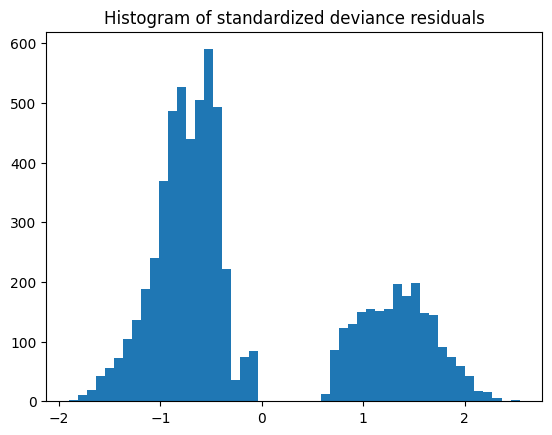

In [27]:
plt.hist(models_logit[3].resid_dev, bins=50)
plt.title('Histogram of standardized deviance residuals');

* В обучающей выборке одна группа deviance residuals наиболее часто встречается около -0.75, а другая - около 1.25. Распределение deviance residuals отклоняется от норамального. Confidence-интервалы предсказаний вероятно не точны.

У обеих групп абсолютные значения стандартизованных deviance residuals больше 2.

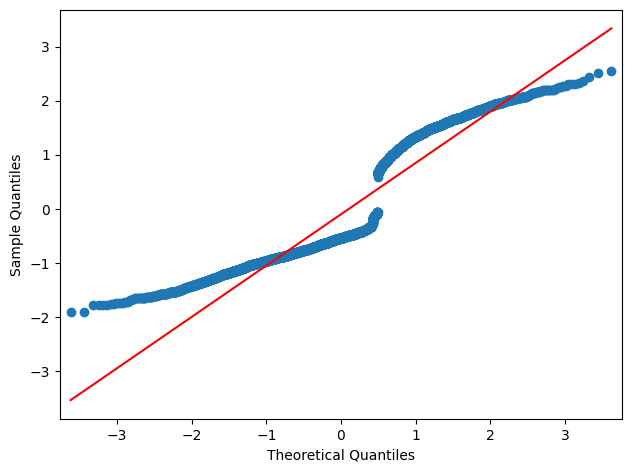

In [28]:
fig = sm.graphics.qqplot(models_logit[3].resid_dev, line='r')
fig.tight_layout(pad=1.0)

* QQ-plot deviance residuals также говорит об отклонении от нормального распределения.

#### 4.1.6. Сохранение модели

In [29]:
save = False
if save:
  file_name = 'model_Logit_auc_7796.joblib'
  model = models_logit[3]
  joblib.dump(model,  PATH + file_name)

### 4.2 GLM

#### 4.2.1. Отбор признаков GLM

In [35]:
selected_features = [
    'Filial',
    #'Type_ts',
    #'VIP',
    'Model',
    'Yr_production',
    #'GAP',
    'KBM',
    #'delta_kbm',
    'deduct',
    #'product',
    'Bank',
    #'channel - map',
    #'Age',
    #'Exp',
    #'discount',
    #'Amount - gr',
    #'premium_car',
    #'price_gr',
    'price_prc',
    'OSAGO_clnt',
    #'M_married',
    #'F_married',
    #'diff_passport_region'
]
df_selected_features['GLM'] = np.where(
    (df_selected_features.index).isin(selected_features), 1, 0
)
len(selected_features)

8

#### 4.2.2. Кросс-валидация

In [36]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[selected_features]
X['intercept'] = 1
y = train[TARGET_NAME]

aic_glm = []
models_glm = []
aucs_glm = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = sm.GLM(
        y[idx_train], X.loc[idx_train], family=sm.genmod.families.Binomial()
    ).fit(method='cg')
    models_glm.append(model)
    aic_glm.append(model.aic)
    print(models_glm[fold].summary2())
    y_pred = model.predict(X.loc[idx_test])
    aucs_glm.append(roc_auc_score(y[idx_test], y_pred))

df_aic['GLM'] = aic_glm
df_auc['GLM'] = aucs_glm

auc_mean = np.array(aucs_glm).mean()
auc_std = np.array(aucs_glm).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')

               Results: Generalized linear model
Model:              GLM              Method:         IRLS       
Link Function:      Logit            AIC:            7460.0681  
Dependent Variable: target           BIC:            -52859.7130
Date:               2023-08-12 19:05 Log-Likelihood: -3721.0    
No. Observations:   6838             LL-Null:        -4245.5    
Df Model:           8                Deviance:       7442.1     
Df Residuals:       6829             Pearson chi2:   6.69e+03   
Converged:          1.0000           Scale:          1.0000     
----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------
Filial           0.7056   0.0901   7.8332 0.0000  0.5290  0.8821
Model            0.7481   0.0819   9.1333 0.0000  0.5876  0.9086
Yr_production    0.6263   0.0725   8.6358 0.0000  0.4842  0.7685
KBM              0.7187   0.0810   8.8780

#### 4.2.3. Area Under the Curve (AUC)

In [37]:
df_auc.round(4)

Logit     GLM
0  0.7695  0.7542
1  0.7576  0.7409
2  0.7636  0.7471
3  0.7796  0.7573
4  0.7262  0.7115
5  0.7357  0.7257
6  0.7663  0.7499
7  0.7587  0.7373
8  0.7238  0.7152
9  0.7202  0.7016

#### 4.2.4. Akaike Information Criterion (AIC)

In [38]:
df_aic.round(1)

Logit     GLM
0  7294.4  7460.1
1  7269.1  7439.8
2  7280.3  7450.0
3  7295.5  7459.0
4  7234.2  7408.7
5  7252.3  7424.2
6  7282.9  7449.3
7  7286.2  7439.2
8  7240.8  7414.7
9  7230.5  7394.9

* GLM использует на 1 признак меньше, чем Logit-модель и имеет более высокий AIC, но AUC в среднем выше у Logit-модели.
* Четвертая модель GLM выглядит более предпочтительной, если судить по AUC (0.7573)

#### 4.2.5. Deviance residuals

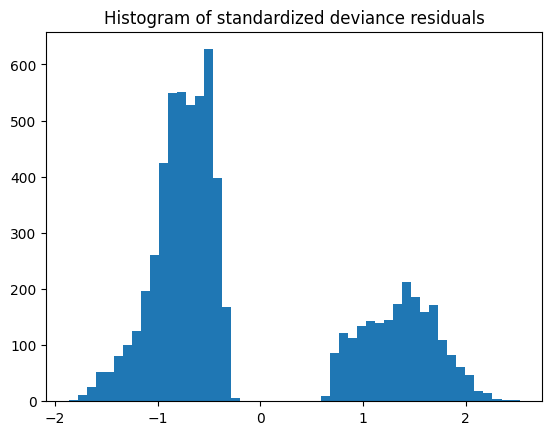

In [39]:
plt.hist(models_glm[3].resid_deviance, bins=50)
plt.title('Histogram of standardized deviance residuals');

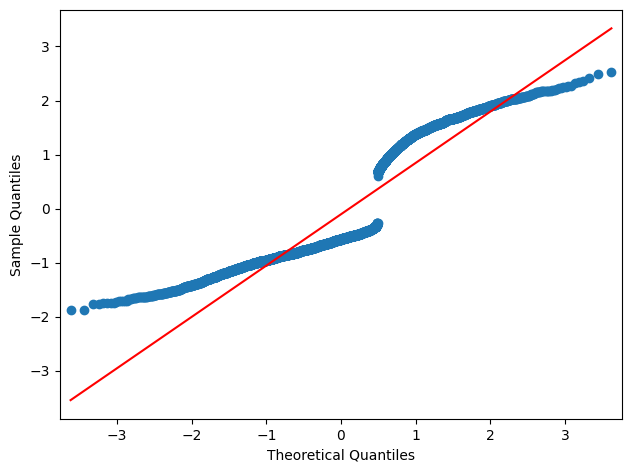

In [29]:
fig = sm.graphics.qqplot(models_glm[3].resid_deviance, line='r')
fig.tight_layout(pad=1.0)

#### 4.2.6. Influence

 Influence основана на одношаговой аппроксимации результатов удаления одного наблюдения. Одношаговые приближения обычно точны для небольших изменений, но недооценивают величину больших изменений.

Хотя большие изменения недооцениваются, influence все же ясно показывает влияние значимых наблюдений.

In [40]:
infl = models_glm[3].get_influence(observed=False)
summ_df = infl.summary_frame()
summ_df.sort_values("cooks_d", ascending=False).head(10)

dfb_Filial  dfb_Model  dfb_Yr_production   dfb_KBM  dfb_deduct  \
4350   -0.064070  -0.011672          -0.019827 -0.008592   -0.048065   
6951   -0.064627  -0.002060          -0.019108 -0.009641   -0.048261   
922     0.013486  -0.051442          -0.015332 -0.021136   -0.046177   
133    -0.056858  -0.047041          -0.001604  0.017969   -0.026686   
6653    0.031660  -0.032799           0.051721 -0.053869   -0.044666   
3255   -0.050159  -0.010193          -0.022408 -0.013818   -0.048370   
7114   -0.058536  -0.024066          -0.025098 -0.000499    0.009186   
1691   -0.058569  -0.020864          -0.024792 -0.000848    0.009030   
4029   -0.058575  -0.020197          -0.024728 -0.000920    0.008997   
1400    0.011379  -0.021300           0.047388 -0.056134   -0.045382   

      dfb_Bank  dfb_price_prc  dfb_OSAGO_clnt  dfb_intercept   cooks_d  \
4350  0.010576      -0.046400       -0.042264       0.087749  0.001372   
6951  0.008328      -0.047941       -0.041798       0.090501  0.001347   
922   0.051907      -0.044680       -0.025504       0.056221  0.001313   
133   0.054890      -0.035385       -0.000654       0.022941  0.001256   
6653 -0.007992      -0.052593       -0.023569       0.054163  0.001247   
3255  0.006038      -0.047827        0.015486       0.069424  0.001173   
7114  0.058087      -0.044985        0.009030       0.027367  0.001172   
1691  0.057145      -0.045368        0.009096       0.028261  0.001148   
4029  0.056948      -0.045447        0.009110       0.028447  0.001143   
1400  0.041081      -0.053806       -0.026251       0.050402  0.001136   

      standard_resid  hat_diag  dffits_internal  
4350        4.826165  0.000530         0.111102  
6951        4.621717  0.000567         0.110101  
922         3.128124  0.001206         0.108717  
133         2.067409  0.002638         0.106324  
6653        2.775780  0.001455         0.105957  
3255        4.239907  0.000587         0.102746  
7114        2.659426  0.001489         0.102714  
1691        2.618816  0.001504         0.101635  
4029        2.610411  0.001507         0.101421  
1400        2.150611  0.002205         0.101097

##### Cook's distance

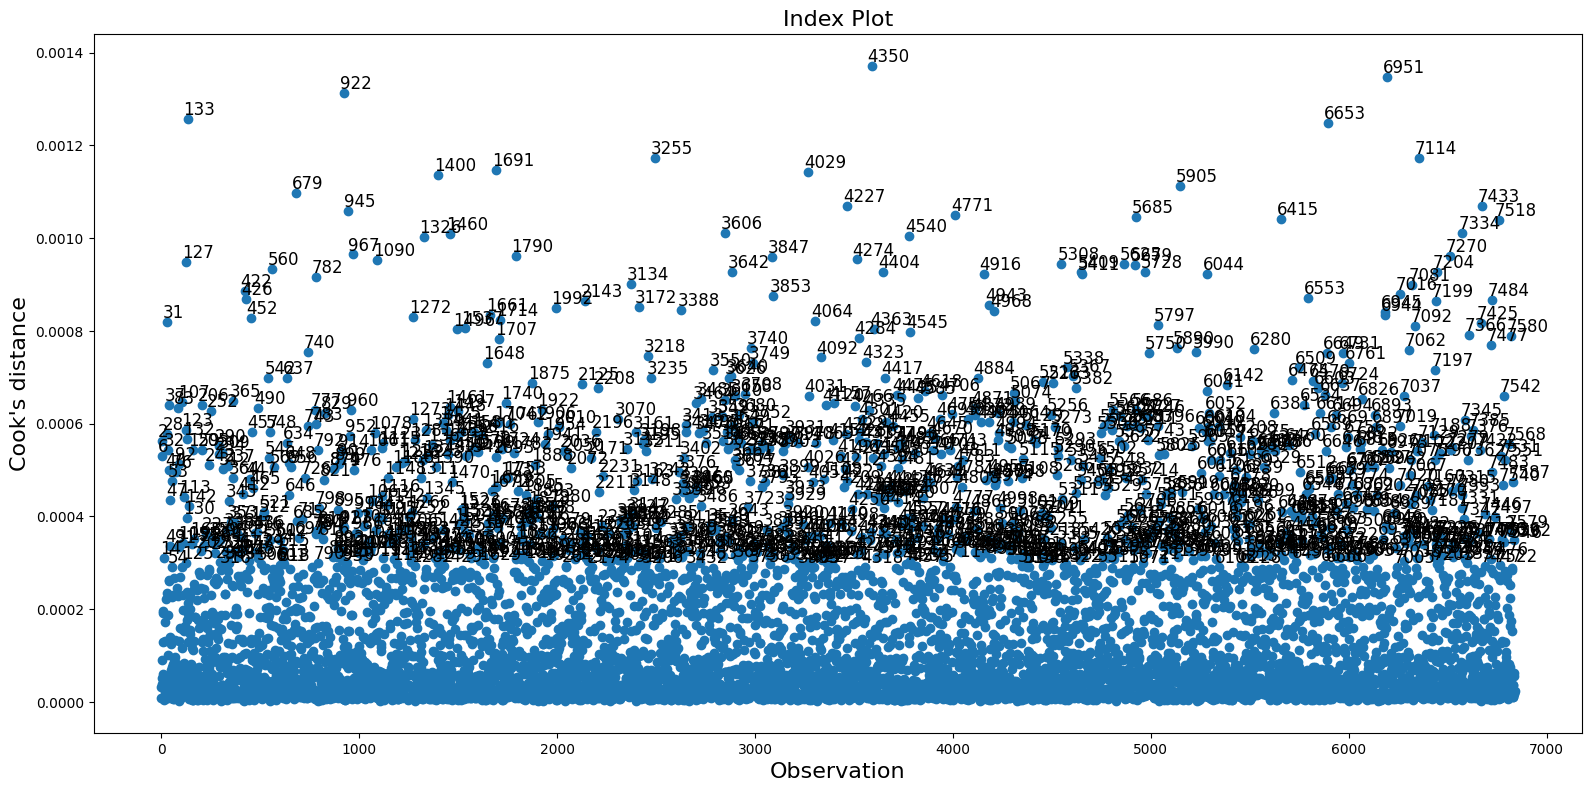

In [41]:
plt.rc("figure", figsize=(16, 8))

fig = infl.plot_index(y_var="cooks_d", threshold=2 * infl.cooks_distance[0].mean())
fig.tight_layout(pad=1.0)

In [42]:
ind = summ_df.sort_values("cooks_d", ascending=False)['cooks_d'].index[:10]
data.loc[ind, :]

ID                 Filial        Type_ts          passport_region  \
4350  4351          Краснодарский  Отечественные        Республика Адыгея   
6951  6952          Краснодарский    Иностранные       Краснодарский край   
922    923  Санкт - Петербургский    Иностранные  Республика Башкортостан   
133    134          Краснодарский    Иностранные       Краснодарский край   
6653  6654  Санкт - Петербургский    Иностранные    Ленинградская область   
3255  3256          Краснодарский  Отечественные       Краснодарский край   
7114  7115          Краснодарский  Отечественные       Краснодарский край   
1691  1692          Краснодарский    Иностранные        Республика Адыгея   
4029  4030          Краснодарский    Иностранные       Краснодарский край   
1400  1401             Московский    Иностранные                   Москва   

      VIP       Brand    Model  Yr_production  GAP             married  ...  \
4350  NaN        LADA   GRANTA           2018  Нет  Не состоит в браке  ...   
6951  NaN  VOLKSWAGEN     POLO           2018  Нет     Состоит в браке  ...   
922   NaN         KIA     CEED           2018  Нет  Не состоит в браке  ...   
133   NaN         KIA   OPTIMA           2017  Нет     Состоит в браке  ...   
6653  NaN         KIA     CEED           2010  Нет  Не состоит в браке  ...   
3255  NaN        LADA     XRAY           2018  Нет  Не состоит в браке  ...   
7114  NaN        LADA   GRANTA           2018  Нет     Состоит в браке  ...   
1691  NaN     HYUNDAI  SOLARIS           2018  Нет     Состоит в браке  ...   
4029  NaN      DATSUN    ON-DO           2018  Нет     Состоит в браке  ...   
1400  NaN     HYUNDAI  SOLARIS           2016  Нет  Не состоит в браке  ...   

      Age  Exp  discount Amount - gr sex premium_car price_gr price_prc  \
4350   60   22      0.90      400000   M           0    20000     0.055   
6951   39   18      1.00      600000   M           0    35000     0.045   
922    35   15      0.95     1000000   M           0    50000     0.045   
133    53   19      1.00     1200000   F           0    65000     0.050   
6653   36   10      0.95      200000   M           0    35000     0.090   
3255   41    7      1.00      600000   F           0    35000     0.055   
7114   35    4      1.00      400000   M           0    20000     0.045   
1691   41   18      0.95      800000   F           0    60000     0.070   
4029   51   33      0.90      400000   M           0    30000     0.065   
1400   32   14      1.00      400000   M           0    30000     0.060   

     OSAGO_clnt target  
4350          0      1  
6951          0      1  
922           0      1  
133           1      1  
6653          0      1  
3255          1      1  
7114          1      1  
1691          1      1  
4029          1      1  
1400          0      1  

[10 rows x 30 columns]

* Это 10 экземпляров обучающей выборки, наиболее влияющих на модель. Если их убрать, модель может существенно измениться.
* Вопрос, включать ли в модель экземпляры с самой большой Cook's distance нуждается в дальнейшей проработке. Возможно, линейная модель не может схватить все закономерности и требуется последовательная линейная комбинация с деревянной моделью.


##### Residuals

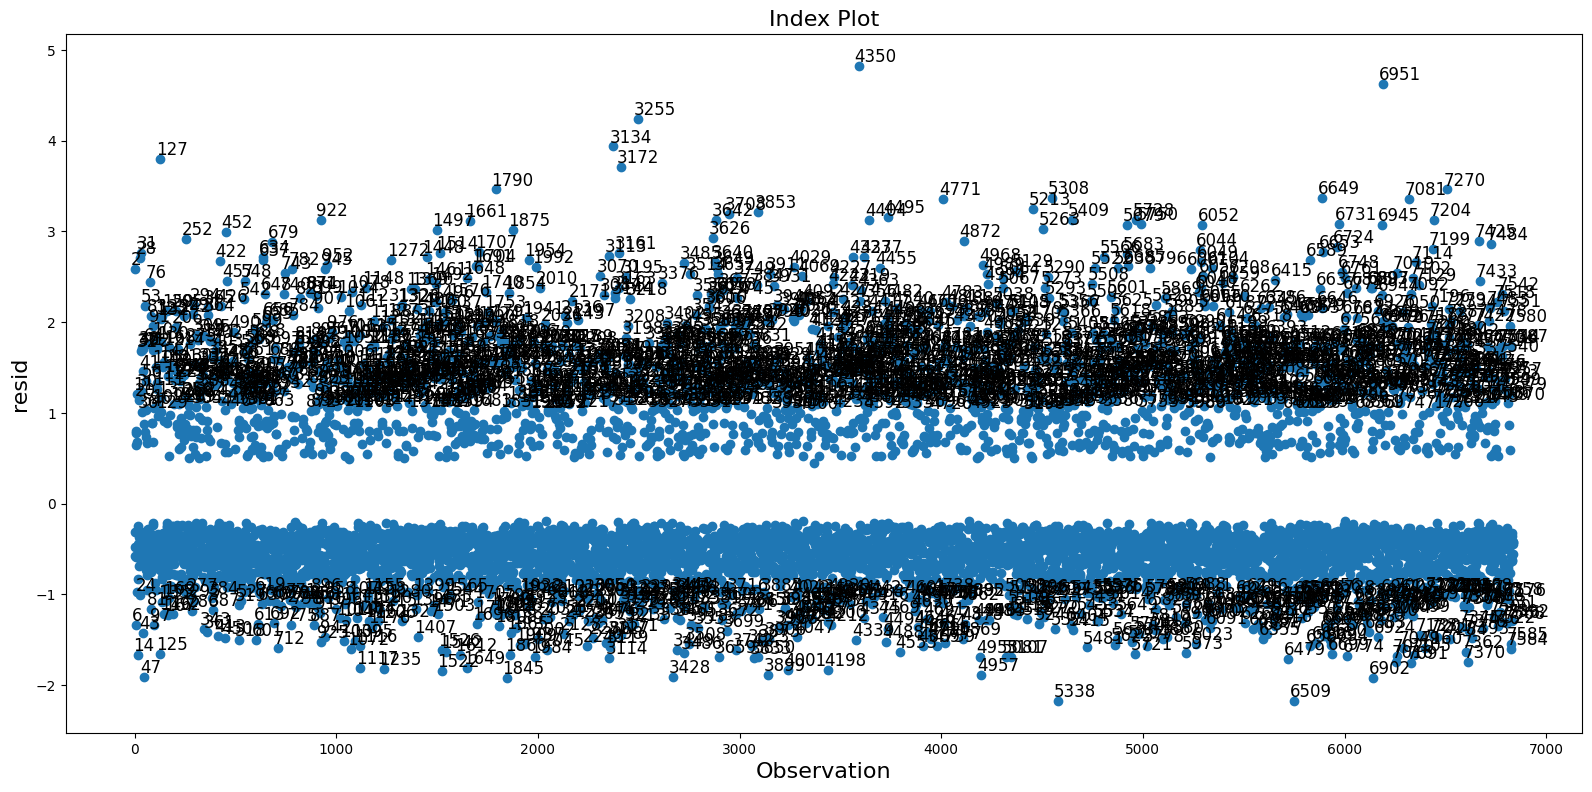

In [45]:
fig = infl.plot_index(y_var="resid", threshold=1)
fig.tight_layout(pad=1.0)

In [46]:
ind_res = summ_df.sort_values("standard_resid", ascending=False)['standard_resid'].index[:10]
data.loc[ind_res, :]

ID          Filial        Type_ts        passport_region  VIP  \
4350  4351   Краснодарский  Отечественные      Республика Адыгея  NaN   
6951  6952   Краснодарский    Иностранные     Краснодарский край  NaN   
3255  3256   Краснодарский  Отечественные     Краснодарский край  NaN   
3134  3135   Нижегородский    Иностранные  Нижегородская область  NaN   
127    128  Ставропольский  Отечественные    Ставропольский край  NaN   
3172  3173        Пермский    Иностранные          Пермский край  NaN   
7270  7271  Магнитогорский  Отечественные   Оренбургская область  NaN   
1790  1791  Магнитогорский  Отечественные    Челябинская область  NaN   
6649  6650     Кемеровский    Иностранные    Кемеровская область  NaN   
5308  5309   Краснодарский    Иностранные      Республика Адыгея  NaN   

           Brand    Model  Yr_production  GAP             married  ...  Age  \
4350        LADA   GRANTA           2018  Нет  Не состоит в браке  ...   60   
6951  VOLKSWAGEN     POLO           2018  Нет     Состоит в браке  ...   39   
3255        LADA     XRAY           2018  Нет  Не состоит в браке  ...   41   
3134      DATSUN    ON-DO           2018  Нет  Не состоит в браке  ...   45   
127         LADA    VESTA           2018  Нет     Состоит в браке  ...   34   
3172  VOLKSWAGEN     POLO           2018  Нет     Состоит в браке  ...   26   
7270        LADA   GRANTA           2018   Да     Состоит в браке  ...   43   
1790        LADA   GRANTA           2018  Нет     Состоит в браке  ...   65   
6649     HYUNDAI  SOLARIS           2018  Нет     Состоит в браке  ...   54   
5308      TOYOTA    CAMRY           2018  Нет     Состоит в браке  ...   69   

      Exp  discount Amount - gr sex premium_car price_gr price_prc OSAGO_clnt  \
4350   22       0.9      400000   M           0    20000     0.055          0   
6951   18       1.0      600000   M           0    35000     0.045          0   
3255    7       1.0      600000   F           0    35000     0.055          1   
3134    7       1.0      400000   M           0    30000     0.060          0   
127     9       0.9      600000   F           0    30000     0.045          1   
3172    8       1.1      600000   F           0    45000     0.070          0   
7270   19       1.0      600000   M           0    35000     0.055          0   
1790   22       1.0      400000   F           0    25000     0.050          0   
6649   16       1.0      800000   F           0    25000     0.035          0   
5308   34       1.0     2000000   M           0    70000     0.060          1   

     target  
4350      1  
6951      1  
3255      1  
3134      1  
127       1  
3172      1  
7270      1  
1790      1  
6649      1  
5308      1  

[10 rows x 30 columns]

In [47]:
set(ind_res) & set(ind)

{3255, 4350, 6951}

In [48]:
summ_df[summ_df['standard_resid'] > 2].shape[0]

271

* Это 10 экземпляров обучающей выборки, на которых модель больше всего ошибается. 3 из них с индексами 4350, 6951 и 3255 входят в top-10 с самой высокой Cook's distance.
* В обучающей выборке значительное количество экземпляров со standard_residual больше 2.

##### Influence plot

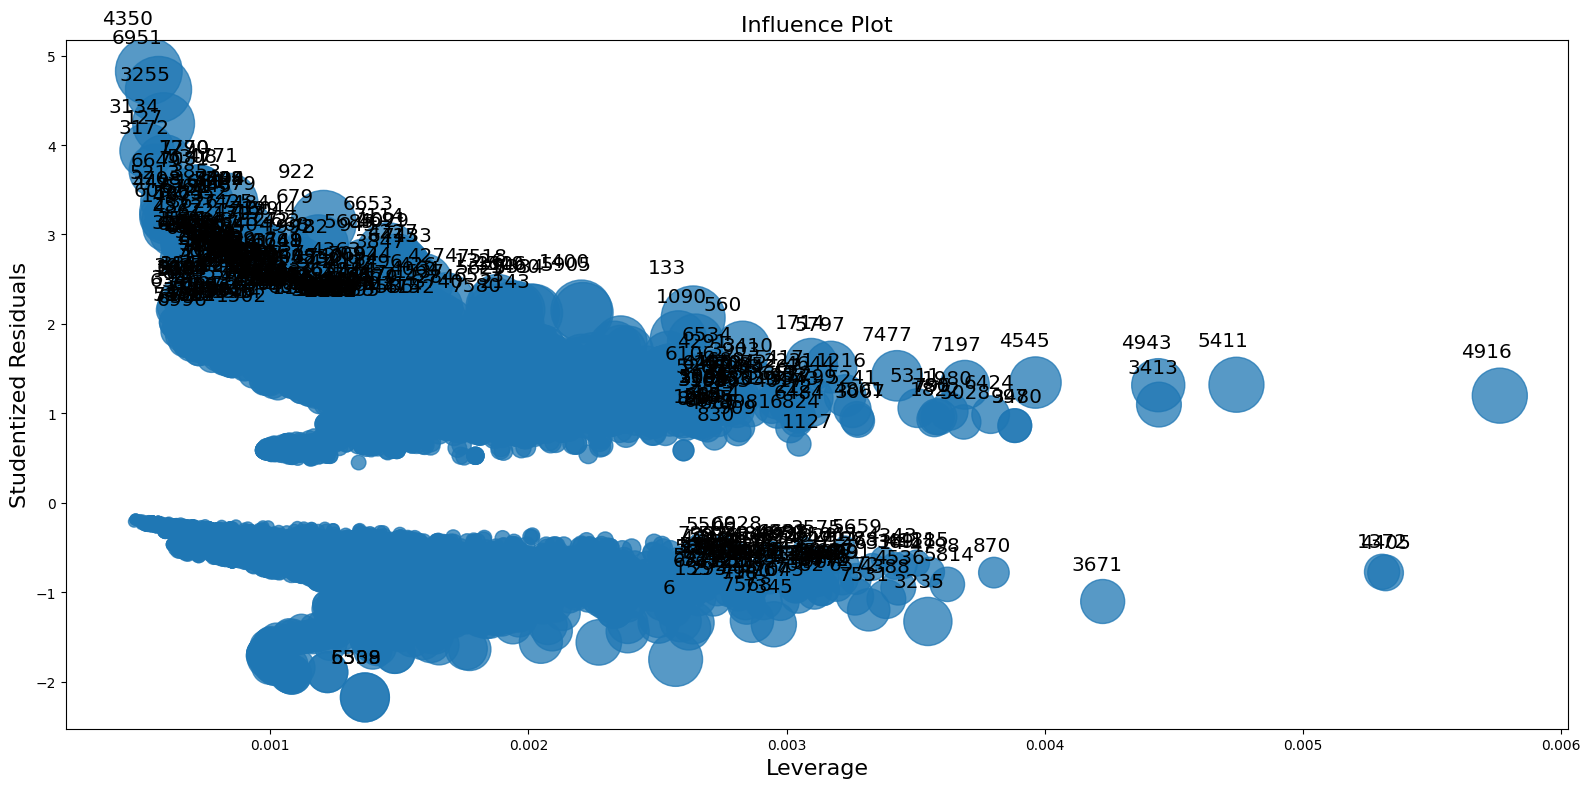

In [37]:
fig = infl.plot_influence()
fig.tight_layout(pad=1.0)

##### dfbetas признаков модели

[dfbetas](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.GLMInfluence.dfbetas.html) - масштабированное изменение оценок параметров.

Одношаговое изменение параметров масштабируется путем деления на стандартную ошибку оценки параметра

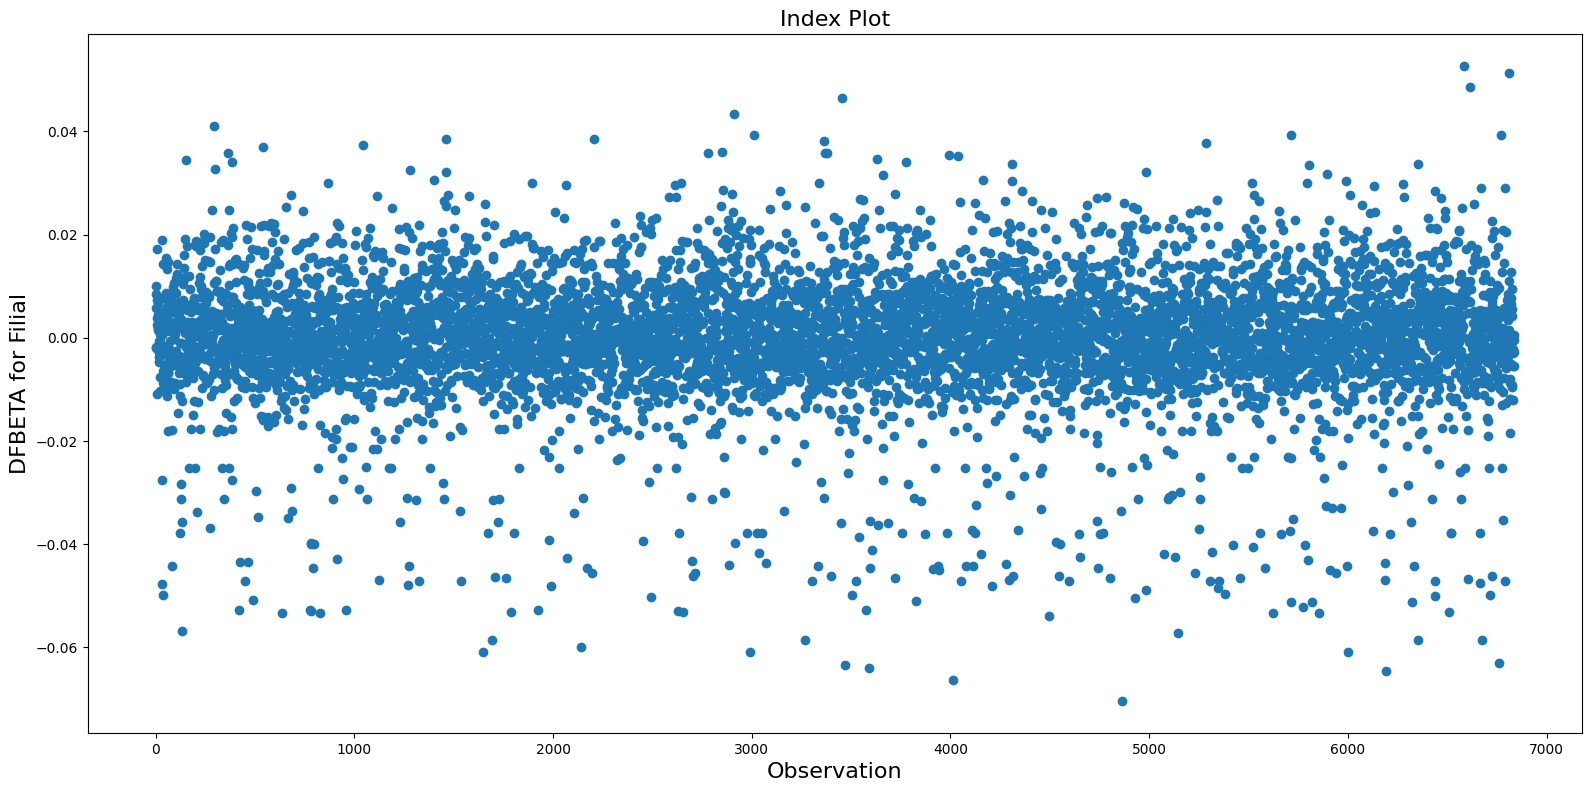

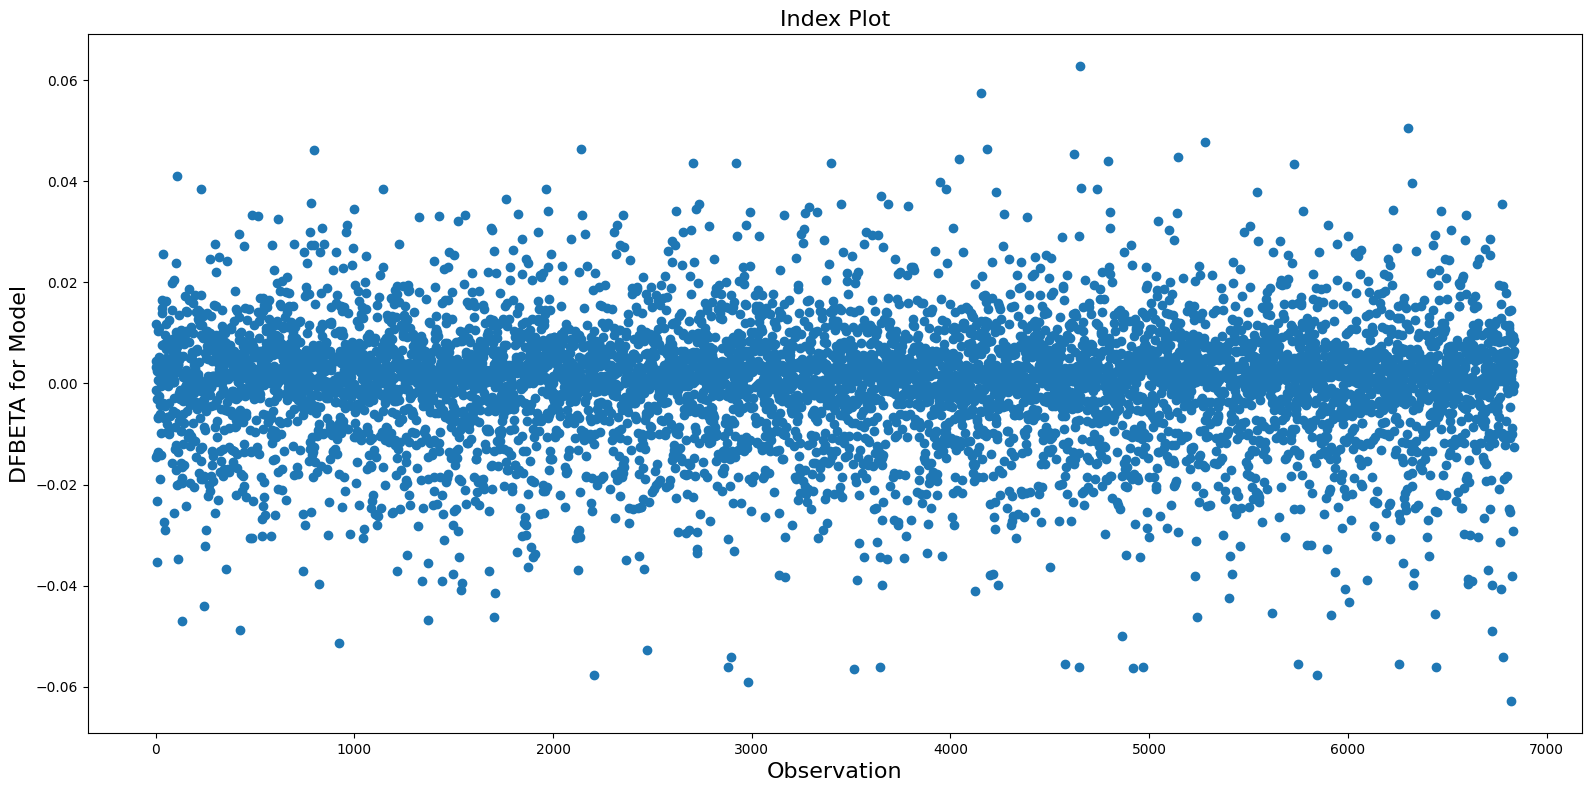

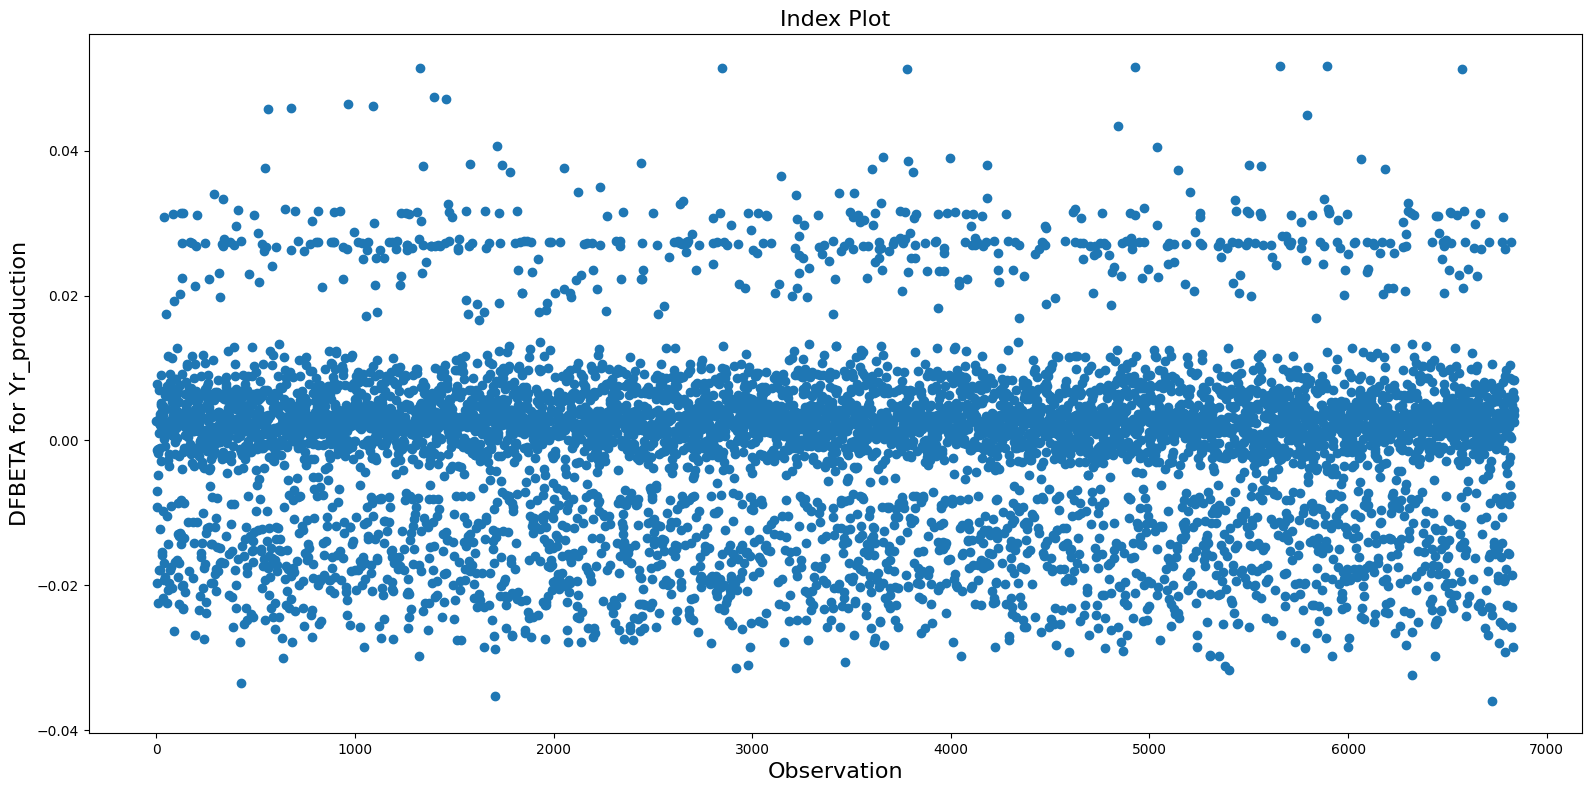

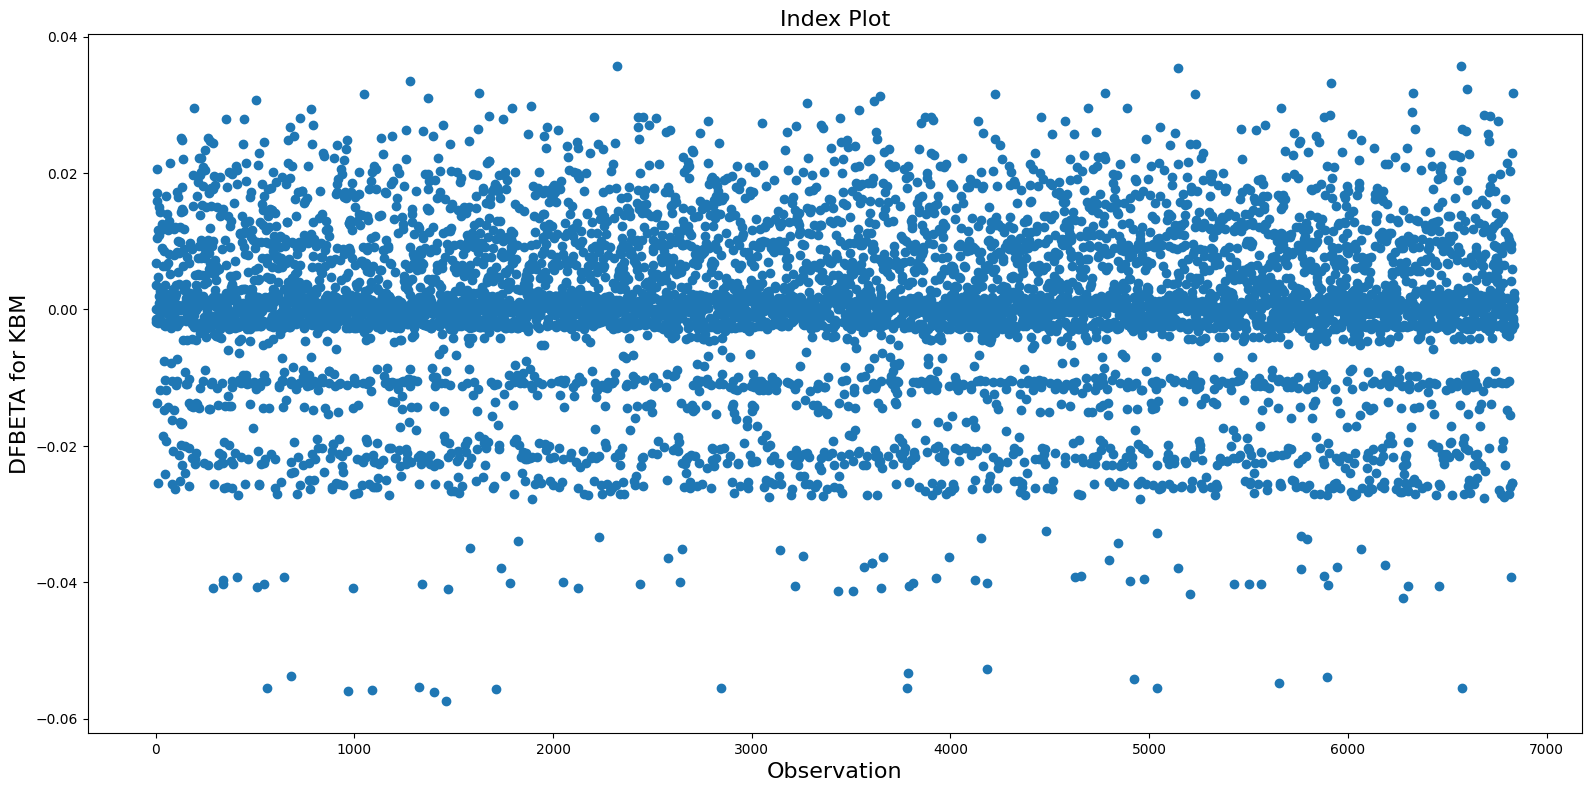

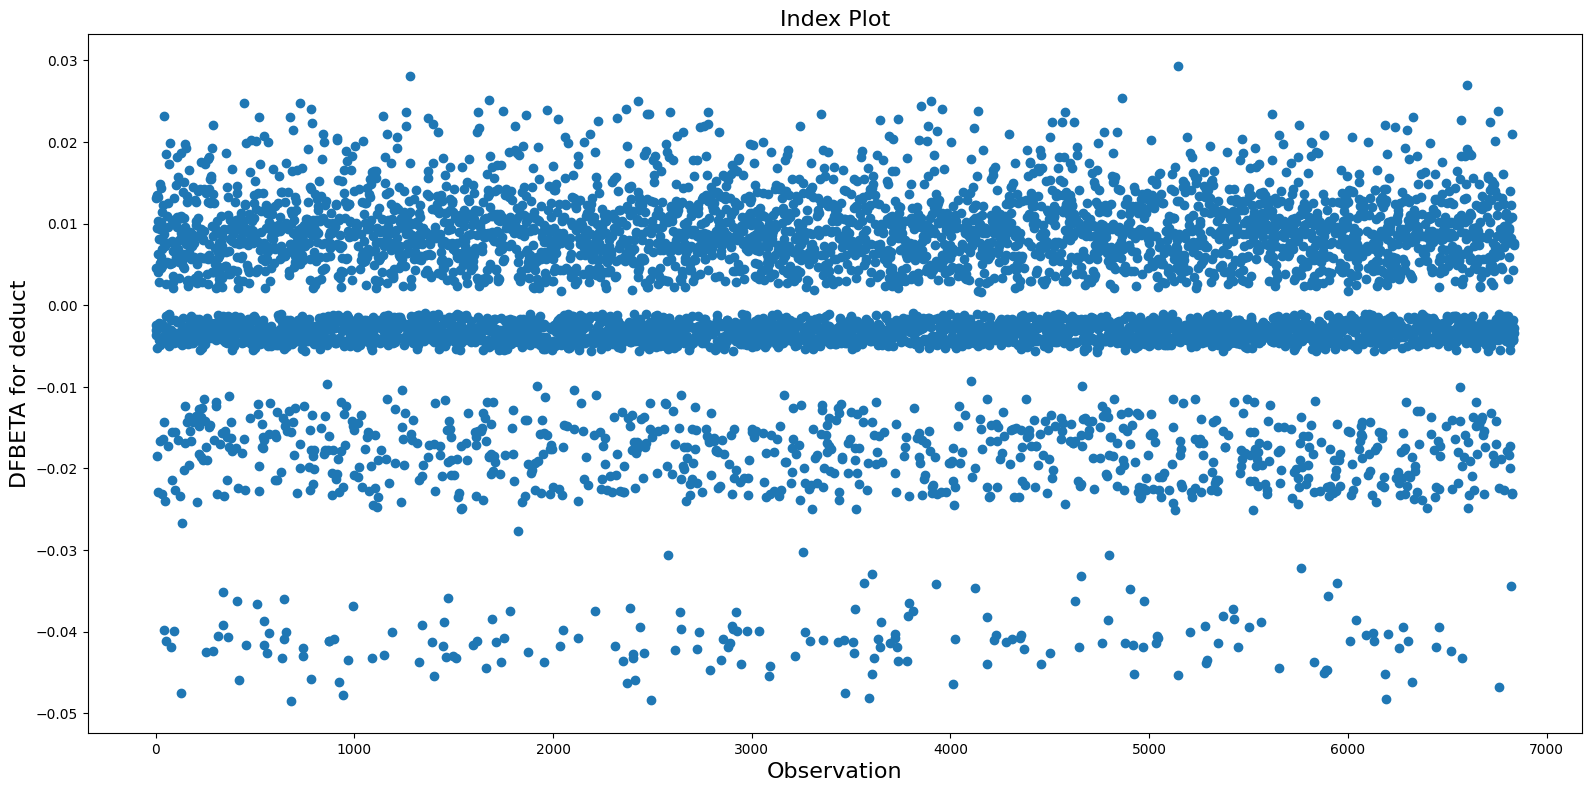

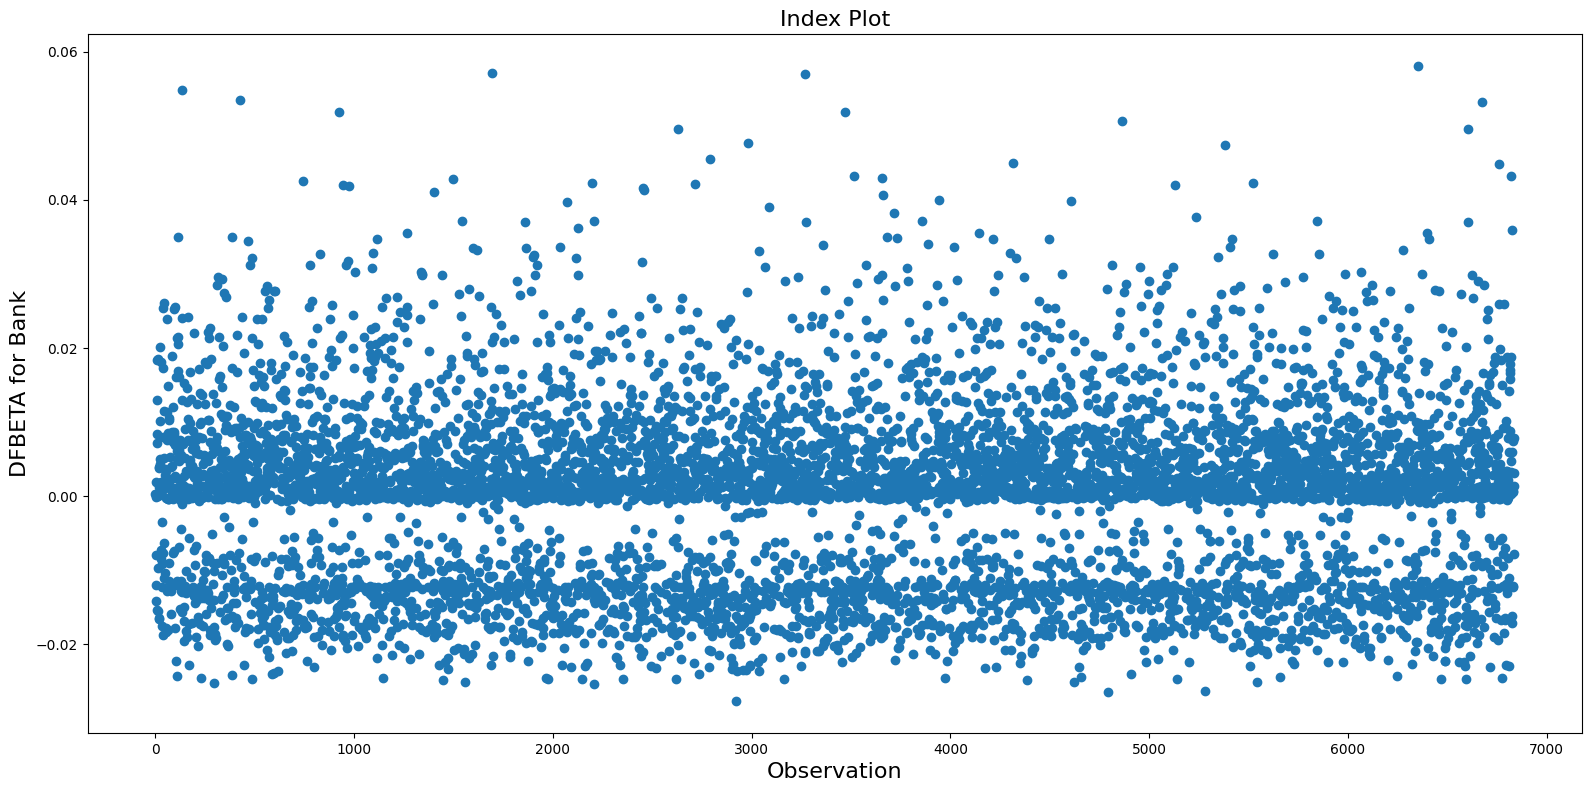

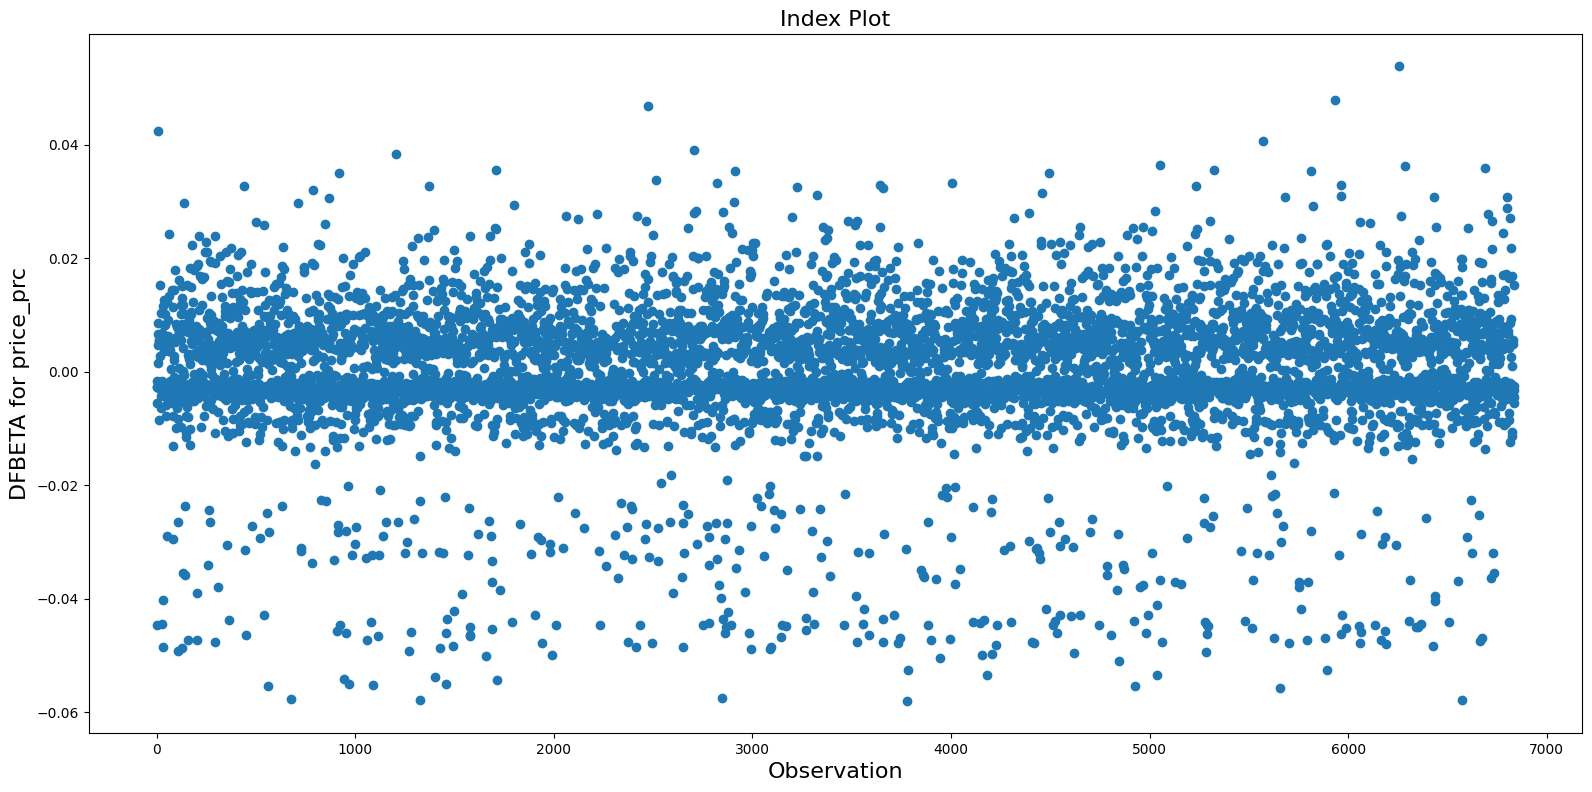

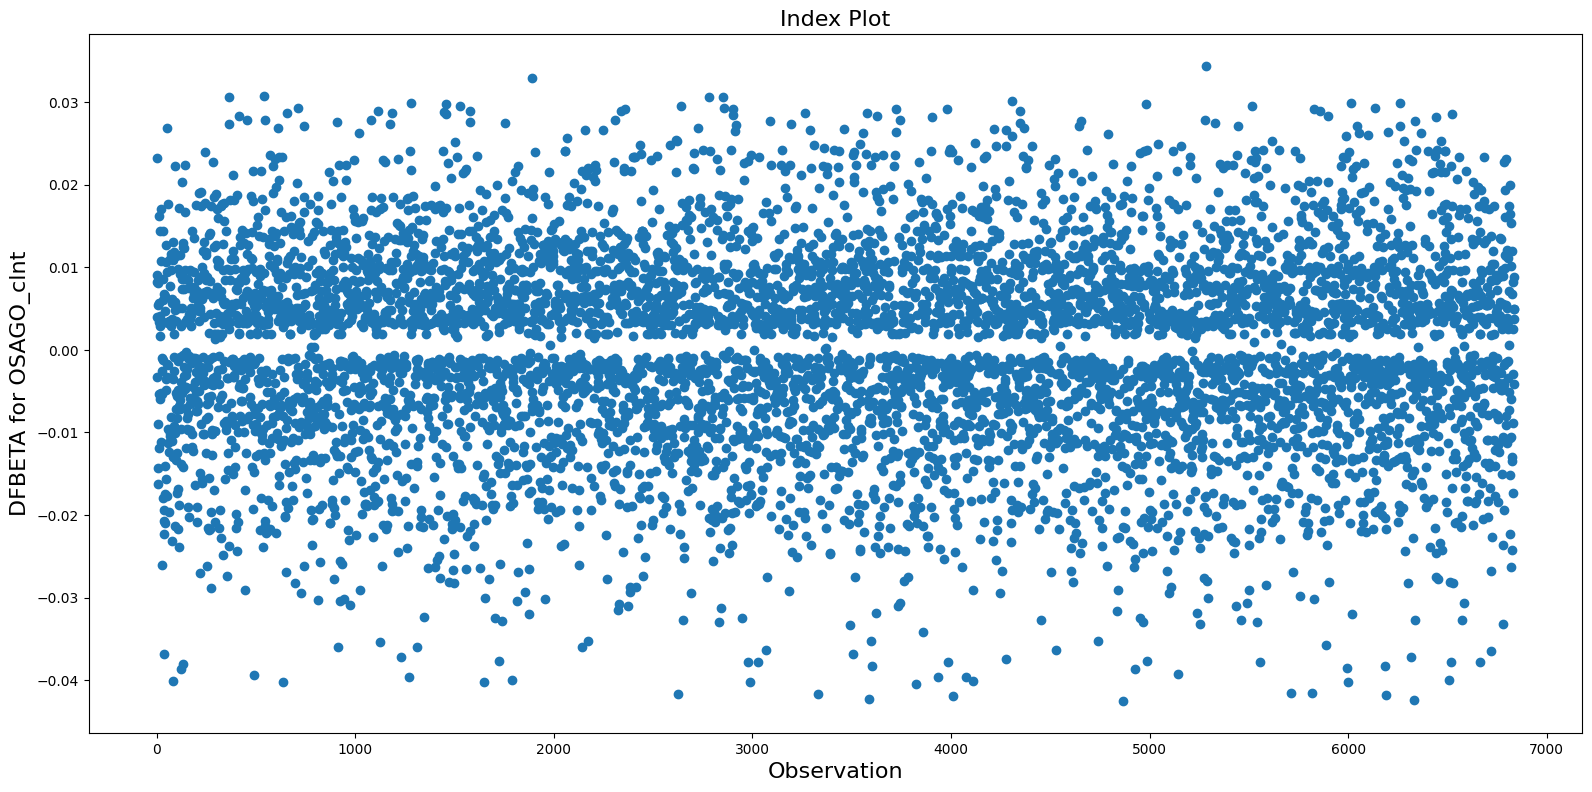

In [38]:
for i in range(len(selected_features)):
  fig = infl.plot_index(y_var="dfbeta", idx=i, threshold=0.5)
  fig.tight_layout(pad=1.0)

#### 4.2.7. Сохранение модели

In [49]:
save = False
if save:
  file_name = 'model_GLM_auc_7573.joblib'
  model = models_glm[3]
  joblib.dump(model,  PATH + file_name)

### 4.3. GLM + Random Forest

#### 4.3.1. Отбор признаков Random Forest

In [50]:
selected_features_rf = [
    'Filial',
    #'Type_ts',
    'VIP',
    'Model',
    'Yr_production',
    'GAP',
    'KBM',
    #'delta_kbm',
    'deduct',
    'product',
    'Bank',
    'channel - map',
    #'Age',
    'Exp',
    'discount',
    'Amount - gr',
    #'premium_car',
    'price_gr',
    'price_prc',
    'OSAGO_clnt',
    #'M_married',
    #'F_married',
    #'diff_passport_region'
]
df_selected_features['RF (with GLM)'] = np.where(
    (df_selected_features.index).isin(selected_features_rf), 1, 0
)
len(selected_features_rf)

16

#### 4.3.2. Кросс-валидация

In [51]:
def get_random_forest_results(
    idx_train, idx_test, linear_model, train, selected_features_rf
):
  y_rf = y[idx_train] - linear_model.predict(X.loc[idx_train])
  X_rf = train.loc[idx_train, selected_features_rf]

  rf = RandomForestRegressor(max_depth=6, random_state=25)
  rf.fit(X_rf, y_rf)

  y_pred_rf = rf.predict(train.loc[idx_test, selected_features_rf])

  return y_pred_rf, rf

In [52]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[selected_features]
X['intercept'] = 1
y = train[TARGET_NAME]

models_glm_rf = []
aucs_glm_rf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test])
    y_pred_rf, rf = get_random_forest_results(
        idx_train, idx_test, model, train, selected_features_rf
    )
    results.loc[idx_test, 'GLM'] = y_pred
    results.loc[idx_test, 'GLM RF'] = y_pred_rf
    models_glm_rf.append(rf)
    aucs_glm_rf.append(roc_auc_score(y[idx_test], y_pred + y_pred_rf))

df_auc['GLM with RF'] = aucs_glm_rf

auc_mean = np.array(aucs_glm_rf).mean()
auc_std = np.array(aucs_glm_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7555 +/- 0.0181


#### 4.3.3. Area Under the Curve (AUC)

In [53]:
df_auc.round(4)

Logit     GLM  GLM with RF
0  0.7695  0.7542       0.7763
1  0.7576  0.7409       0.7613
2  0.7636  0.7471       0.7681
3  0.7796  0.7573       0.7815
4  0.7262  0.7115       0.7406
5  0.7357  0.7257       0.7439
6  0.7663  0.7499       0.7649
7  0.7587  0.7373       0.7624
8  0.7238  0.7152       0.7272
9  0.7202  0.7016       0.7290

In [44]:
save = False
if save:
  file_name = 'model_GLM_rf_auc_7815.joblib'
  model = models_glm_rf[3]
  joblib.dump(model,  PATH + file_name)

#### 4.3.4. Random Forest feature importances

In [59]:
df = pd.DataFrame(
  index=models_glm_rf[3].feature_names_in_.tolist(), columns=['importances']
)
df['importances'] = models_glm_rf[3].feature_importances_
df.sort_values('importances', ascending=False)

importances
product           0.270538
Model             0.241783
Filial            0.131631
Bank              0.034259
Yr_production     0.034056
Amount - gr       0.032274
Exp               0.031265
channel - map     0.030766
deduct            0.030641
KBM               0.030090
VIP               0.026536
price_gr          0.024549
discount          0.022688
price_prc         0.022278
OSAGO_clnt        0.019563
GAP               0.017081

In [60]:
df_selected_features

Logit  GLM  RF (with GLM)
Filial                    1    1              1
Type_ts                   0    0              0
VIP                       0    0              1
Model                     1    1              1
Yr_production             1    1              1
GAP                       0    0              1
KBM                       1    1              1
delta_kbm                 0    0              0
deduct                    1    1              1
product                   1    0              1
Bank                      1    1              1
channel - map             0    0              1
Age                       0    0              0
Exp                       0    0              1
discount                  0    0              1
Amount - gr               0    0              1
premium_car               0    0              0
price_gr                  0    0              1
price_prc                 1    1              1
OSAGO_clnt                1    1              1
M_married                 0    0              0
F_married                 0    0              0
diff_passport_region      0    0              0

### 4.4. GLM + LightGBM

#### 4.4.1. Отбор признаков LightGBM

In [61]:
selected_features_lgb = [
    'Filial',
    #'Type_ts',
    #'VIP',
    'Model',
    'Yr_production',
    #'GAP',
    'KBM',
    #'delta_kbm',
    'deduct',
    'product',
    'Bank',
    'channel - map',
    'Age',
    'Exp',
    #'discount',
    'Amount - gr',
    #'premium_car',
    'price_gr',
    'price_prc',
    'OSAGO_clnt',
    'M_married',
    #'F_married',
    #'diff_passport_region'
]
df_selected_features['LGB (with GLM)'] = np.where(
    (df_selected_features.index).isin(selected_features_lgb), 1, 0
)
len(selected_features_lgb)

15

#### 4.4.2. Кросс-валидация

In [62]:
def get_boosting_results(
    idx_train, idx_test, linear_model, train, selected_features_lgb
):
  params_lgb = {
      'task': 'train',
      'boosting': 'gbdt',
      'objective': 'regression',
      'num_leaves': 20,
      'learnnig_rage': 0.00001,
      'metric': 'mse',
      'early_stopping_rounds': 30,
      'verbose': -1
  }
  n = int(len(idx_train) * 0.85)
  idx_train_lgb = np.random.choice(idx_train, n, replace=False)
  idx_valid_lgb  = list(set(idx_train) - set(idx_train_lgb))

  X_train_lgb = train.loc[idx_train_lgb, selected_features_lgb]
  y_train_lgb = y[idx_train_lgb] - linear_model.predict(X.loc[idx_train_lgb])
  X_valid_lgb = train.loc[idx_valid_lgb, selected_features_lgb]
  y_valid_lgb = y[idx_valid_lgb] - linear_model.predict(X.loc[idx_valid_lgb])

  dtrain = lgb.Dataset(X_train_lgb, y_train_lgb)
  dvalid = lgb.Dataset(X_valid_lgb, y_valid_lgb, reference=dtrain)

  model_lgb = lgb.train(
      params_lgb,
      train_set=dtrain,
      valid_sets=dvalid,
  )
  y_pred_lgb = model_lgb.predict(train.loc[idx_test, selected_features_lgb])

  return y_pred_lgb, model_lgb

In [66]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[selected_features]
X['intercept'] = 1
y = train[TARGET_NAME]

models_lgb = []
aucs_glm_lgb = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    model = models_glm[fold]
    y_pred = model.predict(X.loc[idx_test])
    y_pred_lgb, model_lgb = get_boosting_results(
        idx_train, idx_test, model, train, selected_features_lgb
    )
    models_lgb.append(model_lgb)
    aucs_glm_lgb.append(roc_auc_score(y[idx_test], y_pred + y_pred_lgb))

df_auc['GLM with LGB'] = aucs_glm_lgb

auc_mean = np.array(aucs_glm_lgb).mean()
auc_std = np.array(aucs_glm_lgb).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7547 +/- 0.0198


#### 4.4.3. Area Under the Curve (AUC)

In [67]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB
0  0.7695  0.7542       0.7763        0.7816
1  0.7576  0.7409       0.7613        0.7623
2  0.7636  0.7471       0.7681        0.7676
3  0.7796  0.7573       0.7815        0.7777
4  0.7262  0.7115       0.7406        0.7367
5  0.7357  0.7257       0.7439        0.7378
6  0.7663  0.7499       0.7649        0.7551
7  0.7587  0.7373       0.7624        0.7733
8  0.7238  0.7152       0.7272        0.7316
9  0.7202  0.7016       0.7290        0.7236

#### 4.4.4. LightGBM feature importances

In [68]:
df_lgb = pd.DataFrame(index=models_lgb[0].feature_name(), columns=['importances'])
df_lgb['importances'] = models_lgb[0].feature_importance()
df_lgb.sort_values('importances', ascending=False)

importances
Model                  384
Filial                 230
Bank                    64
channel_-_map           63
Amount_-_gr             61
M_married               59
deduct                  53
Exp                     53
OSAGO_clnt              51
Yr_production           44
KBM                     42
Age                     37
product                 35
price_gr                34
price_prc               25

In [69]:
df_selected_features

Logit  GLM  RF (with GLM)  LGB (with GLM)
Filial                    1    1              1               1
Type_ts                   0    0              0               0
VIP                       0    0              1               0
Model                     1    1              1               1
Yr_production             1    1              1               1
GAP                       0    0              1               0
KBM                       1    1              1               1
delta_kbm                 0    0              0               0
deduct                    1    1              1               1
product                   1    0              1               1
Bank                      1    1              1               1
channel - map             0    0              1               1
Age                       0    0              0               1
Exp                       0    0              1               1
discount                  0    0              1               0
Amount - gr               0    0              1               1
premium_car               0    0              0               0
price_gr                  0    0              1               1
price_prc                 1    1              1               1
OSAGO_clnt                1    1              1               1
M_married                 0    0              0               1
F_married                 0    0              0               0
diff_passport_region      0    0              0               0

### 4.5. Logit + Random Forest

#### 4.5.1. Отбор признаков Logit + Random Forest

In [70]:
selected_features_logit_rf = [
    'Filial',
    #'Type_ts',
    'VIP',
    'Model',
    'Yr_production',
    'GAP',
    'KBM',
    #'delta_kbm',
    'deduct',
    #'product',
    'Bank',
    'channel - map',
    'Age',
    'Exp',
    'discount',
    'Amount - gr',
    'premium_car',
    'price_gr',
    'price_prc',
    'OSAGO_clnt',
    'M_married',
    'F_married',
    'diff_passport_region'
]
df_selected_features['RF (with Logit)'] = np.where(
    (df_selected_features.index).isin(selected_features_logit_rf), 1, 0
)
len(selected_features_logit_rf)

20

#### 4.5.2. Кросс-валидация

In [71]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)
X = train[selected_features_logit]
X['intercept'] = 1
y = train[TARGET_NAME]

models_logit_rf = []
aucs_logit_rf = []
for fold, (idx_train, idx_test) in enumerate(cv.split(X, y)):
    log_reg = models_logit[fold]
    y_pred = log_reg.predict(X.loc[idx_test])
    y_pred_logit_rf, rf = get_random_forest_results(
        idx_train, idx_test, log_reg, train, selected_features_logit_rf
    )
    models_logit_rf.append(rf)
    aucs_logit_rf.append(roc_auc_score(y[idx_test], y_pred + y_pred_logit_rf))

df_auc['Logit with RF'] = aucs_logit_rf

auc_mean = np.array(aucs_logit_rf).mean()
auc_std = np.array(aucs_logit_rf).std()
print(f'\nauc: {round(auc_mean, 4)} +/- {round(auc_std, 4)}')


auc: 0.7555 +/- 0.0196


#### 4.5.3. Area Under the Curve (AUC)

In [72]:
df_auc.round(4)

Logit     GLM  GLM with RF  GLM with LGB  Logit with RF
0  0.7695  0.7542       0.7763        0.7816         0.7764
1  0.7576  0.7409       0.7613        0.7623         0.7640
2  0.7636  0.7471       0.7681        0.7676         0.7659
3  0.7796  0.7573       0.7815        0.7777         0.7874
4  0.7262  0.7115       0.7406        0.7367         0.7347
5  0.7357  0.7257       0.7439        0.7378         0.7427
6  0.7663  0.7499       0.7649        0.7551         0.7630
7  0.7587  0.7373       0.7624        0.7733         0.7647
8  0.7238  0.7152       0.7272        0.7316         0.7279
9  0.7202  0.7016       0.7290        0.7236         0.7286

In [73]:
df_auc.mean()

Logit            0.750107
GLM              0.734073
GLM with RF      0.755506
GLM with LGB     0.754735
Logit with RF    0.755521
dtype: float64

In [74]:
df_auc.std()

Logit            0.021549
GLM              0.019491
GLM with RF      0.019125
GLM with LGB     0.020895
Logit with RF    0.020684
dtype: float64

In [75]:
df_aic.round(1)

Logit     GLM
0  7294.4  7460.1
1  7269.1  7439.8
2  7280.3  7450.0
3  7295.5  7459.0
4  7234.2  7408.7
5  7252.3  7424.2
6  7282.9  7449.3
7  7286.2  7439.2
8  7240.8  7414.7
9  7230.5  7394.9

In [76]:
df_aic.mean()

Logit    7266.611070
GLM      7433.974253
dtype: float64

* Лучшая модель - композиция Logit + RF на 4 фолде (AUC 0.7874)

* В целом, ансамбль из линейной комбинации GLM и Random Forest выглядит предпочтительнее:
  * AUC практически такой же как у комбинации Logit + RF, а дисперсия самая низкая.
  * AIC у GLM выше, чем у Logit (7434 vs 7267) - число переменных у GLM на одну меньше, чем у Logit

#### 4.5.4. Random Forest feature importances

In [77]:
df = pd.DataFrame(
    index=models_logit_rf[3].feature_names_in_.tolist(), columns=['importances']
)
df['importances'] = models_logit_rf[3].feature_importances_
df.sort_values('importances', ascending=False)

importances
Model                    0.263633
Filial                   0.176460
Yr_production            0.047098
channel - map            0.043859
Amount - gr              0.040273
Bank                     0.039568
Exp                      0.037654
KBM                      0.036576
VIP                      0.031526
deduct                   0.031506
OSAGO_clnt               0.029178
price_prc                0.028906
price_gr                 0.028450
discount                 0.026298
M_married                0.026246
Age                      0.025624
GAP                      0.024898
F_married                0.024775
diff_passport_region     0.022859
premium_car              0.014613

In [78]:
df_selected_features

Logit  GLM  RF (with GLM)  LGB (with GLM)  \
Filial                    1    1              1               1   
Type_ts                   0    0              0               0   
VIP                       0    0              1               0   
Model                     1    1              1               1   
Yr_production             1    1              1               1   
GAP                       0    0              1               0   
KBM                       1    1              1               1   
delta_kbm                 0    0              0               0   
deduct                    1    1              1               1   
product                   1    0              1               1   
Bank                      1    1              1               1   
channel - map             0    0              1               1   
Age                       0    0              0               1   
Exp                       0    0              1               1   
discount                  0    0              1               0   
Amount - gr               0    0              1               1   
premium_car               0    0              0               0   
price_gr                  0    0              1               1   
price_prc                 1    1              1               1   
OSAGO_clnt                1    1              1               1   
M_married                 0    0              0               1   
F_married                 0    0              0               0   
diff_passport_region      0    0              0               0   

                      RF (with Logit)  
Filial                              1  
Type_ts                             0  
VIP                                 1  
Model                               1  
Yr_production                       1  
GAP                                 1  
KBM                                 1  
delta_kbm                           0  
deduct                              1  
product                             0  
Bank                                1  
channel - map                       1  
Age                                 1  
Exp                                 1  
discount                            1  
Amount - gr                         1  
premium_car                         1  
price_gr                            1  
price_prc                           1  
OSAGO_clnt                          1  
M_married                           1  
F_married                           1  
diff_passport_region                1

In [79]:
save = False
if save:
  file_name = 'model_Logit_rf_auc_7874.joblib'
  model = models_logit_rf[3]
  joblib.dump(model,  PATH + file_name)

## 5. Определение точки отсечения для модели классификации.

In [80]:
results['GLM RF comb'] = results['GLM'] + results['GLM RF']
results.loc[results['GLM RF comb'] < 0, 'GLM RF comb'] = 0

precision, recall, thresholds = precision_recall_curve(
    results[TARGET_NAME], results['GLM RF comb']
)

In [81]:
df = pd.DataFrame(
    zip(precision[:-1], recall[:-1], thresholds),
    columns=['precision', 'recall', 'thresholds']
)
df['F1-score'] = 2 * df['precision'] * df['recall'] / (df['precision'] + df['recall'])
thrs = df.loc[df['F1-score'].argmax(), 'thresholds'].round(4)
thrs

0.2697

* В качестве критерия выбора точки отсечения будем использовать максимизацию F1-score
* Возможны и другие бизнес-критерии выбора точки отсечения, свзанные со стоимостью обработки ложно-положительных и ложно-отрицательных ответов модели.

In [82]:
results['y_pred'] = np.where(results['GLM RF comb'] >= thrs, 1, 0)
results.sample(2)

target       GLM    GLM RF  GLM RF comb  y_pred
7115       1  0.743317  0.002929     0.746247       1
6452       0  0.297598  0.080433     0.378030       1

In [83]:
print(classification_report(results[TARGET_NAME], results['y_pred']))

              precision    recall  f1-score   support

           0       0.85      0.57      0.68      5226
           1       0.45      0.79      0.58      2372

    accuracy                           0.64      7598
   macro avg       0.65      0.68      0.63      7598
weighted avg       0.73      0.64      0.65      7598



## 6. Инференс

In [84]:
model_GLM = joblib.load(PATH + 'model_GLM_auc_7573.joblib')
model_GLM_rf = joblib.load(PATH + 'model_GLM_rf_auc_7815.joblib')

In [85]:
selected = df_selected_features.loc[
    df_selected_features['GLM'] == 1, 'GLM'
].index.tolist()
X_test = test[selected]
X_test['intercept'] = 1
y_pred = model_GLM.predict(X_test)

selected = df_selected_features.loc[
    df_selected_features['RF (with GLM)'] == 1, 'RF (with GLM)'
].index.tolist()
y_pred_rf = model_GLM_rf.predict(test.loc[:, selected])
y_pred += y_pred_rf

In [86]:
results = pd.DataFrame(columns=['ID', 'score', 'predictions'])
results['ID'] = test['ID']
results['score'] = np.where(y_pred < 0, 0, y_pred)
results['predictions'] = np.where(y_pred >= thrs, 1, 0)
results

ID     score  predictions
7598    7599  0.004191            0
7599    7600  0.502802            1
7600    7601  0.298418            1
7601    7602  0.452797            1
7602    7603  0.301498            1
...      ...       ...          ...
10858  10859  0.276576            1
10859  10860  0.350616            1
10860  10861  0.273951            1
10861  10862  0.107127            0
10862  10863  0.179356            0

[3265 rows x 3 columns]

In [87]:
results.to_csv(PATH + "GLM_rf_predictions.csv", index=False)